# The full information can be found in this folder:
https://github.com/fizikaislove/QCreator/tree/master/Meshing

In [1]:
import sys

# sys.path.append("/usr/local/lib/python3.7/site-packages/meshpy")
import meshpy.triangle as triangle
import meshpy.tet as tet
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# sys.path.append("/usr/local/lib/python3.7/site-packages/gdspy")
import gdspy
import subprocess
import pandas as pd
import pyclipper

# module for detecting inner points
from shapely.geometry.polygon import Polygon
from shapely.geometry import Point

# Functions

In [2]:
def simplify(points):
    """
    Parameters
    ----------
    pol_points : list(list(coord_x, coord_y))
    list of points of WSP
    
    Returns
    -------
    list(new_polygon_1, ...), where
    new_polygon_i : list(list(coord_x, coord_y))
    """
    return pyclipper.SimplifyPolygon(points)


def round_trip_connect(start, end):
    return [(i, i + 1) for i in range(start, end)] + [(end, start)]


def inner_point(polygon):
    point = Polygon(polygon).representative_point()
    x, y = point.x, point.y
    return x, y


def create_mesh(WSP_points, max_volume=10000, min_angle=25):
    outer_polygon, *inner_polygons = simplify(WSP_points)
    inner_points_of_holes = [inner_point(pol) for pol in inner_polygons]
    
    points = outer_polygon
    
    last_point_number = len(outer_polygon) - 1
    facets = round_trip_connect(0, last_point_number)
    
    for pol in inner_polygons:
        points.extend(pol)
        facets.extend(round_trip_connect(last_point_number+1, last_point_number+len(pol)))
        last_point_number = last_point_number + len(pol)
        
    info = triangle.MeshInfo()
    info.set_points(points)
    info.set_holes(inner_points_of_holes)
    info.set_facets(facets)
    
    mesh = triangle.build(info, max_volume=max_volume, min_angle=min_angle)
    
    mesh_points = np.array(mesh.points)
    mesh_tris = np.array(mesh.elements)
    mesh_facets = np.array(mesh.facets)
    
    return mesh_points, mesh_tris

    
def plot_mesh(mesh_points,mesh_tris,*arg):
    plt.triplot(mesh_points[:, 0], mesh_points[:, 1], mesh_tris,arg)
    
def write_dat(points,f):
    if type(f) is str:
            f = open(f, 'w')
    counts=len(points)
    f.write('0 exported from the LayoutEditor ( www.LayoutEditor.net )\n')
    f.write('* **************************************************\n')
    f.write('* \n')
    f.write('* input file for FastCap automaticly generated by the LayoutEditor\n')
    f.write('* \n')
    f.write('* **************************************************\n')
    for i in range(counts):
        f.write('T ')
        for j in range(10):
            f.write(str(points[i][j]))
            f.write(' ')
        f.write('\n')
    f.write('*')
    f.close()
def to_fastcap(mesh_points,mesh_tris,number):
    z=np.zeros((len(mesh_points[:, 0]),))
    to_output=list()
    for i in range(len(mesh_points[:, 0])):
        to_output.append([mesh_points[i, 0], mesh_points[i, 1],z[i]])
    test=[]
    for index in range(len(mesh_tris)):
        test.append(np.asarray([to_output[mesh_tris[index][2]],to_output[mesh_tris[index][1]],to_output[mesh_tris[index][0]]]))
    test=np.asarray(test)
    points_file=test.reshape((len(mesh_tris),9))
    points_to_file=np.insert(points_file,0,number,axis=1)
    return points_to_file
    
  

# Read conductors from a gds file

In [3]:
layers=[0,1,2,3]
new_cells=[gdspy.GdsLibrary()]*len(layers)
cells=[]
cell_name='result'
path=r"E:\Github\QCreator\Meshing\test1.gds"
for i,num_layer in enumerate(layers):
    cells.append(new_cells[i].read_gds(infile=path).cell_dict[cell_name])
    cells[i].remove_polygons(lambda pts, layer, datatype:layer != i)

Use this cell to check the correctness of the studied conductors

In [3]:
num=1
gdspy.LayoutViewer(cells=cells[num])

<gdspy.viewer.LayoutViewer object .!layoutviewer>

# Preparation of the conductors to the meshpy format

In [4]:
conductors=[]
def create_cond(cell):
    polygons=[]
    for fig in cell.get_polygons():
        polygons.append([tuple(fig[i]) for i in range(len(fig))])
    return polygons
for i in range(len(layers)):
    conductors.append(create_cond(cells[i]))

# Meshing

In [5]:
meshpy_volume=10
mesh_figures_points=[]
mesh_figures_tris=[]
total=0
for num, polygons in enumerate(conductors):
    mesh_points_list = []
    mesh_tris_list = []
    total_length=0
    for conductor, volume in zip(polygons, [meshpy_volume]*len(polygons)):
        data = create_mesh(conductor, max_volume=volume)
        mesh_points_list.append(data[0])
        mesh_tris_list.append(data[1])
        total_length+=len(data[1])
    total+=total_length
    mesh_figures_points.append(mesh_points_list)
    mesh_figures_tris.append(mesh_tris_list)
    print('For '+str(num)+' conductor '+'total length is: ', total_length)
print("Sum :",total)

For 0 conductor total length is:  104346
For 1 conductor total length is:  4386
For 2 conductor total length is:  4887
For 3 conductor total length is:  4905
Sum : 118524


In [17]:
%matplotlib qt5

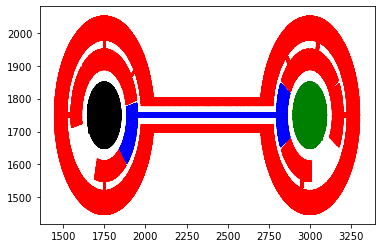

In [6]:
colors=['r','b','k','g']
for num,color in enumerate(colors):
    for i in range(len(conductors[num])):
        plot_mesh(mesh_figures_points[num][i],mesh_figures_tris[num][i],color)

# Write into a file

In [7]:
list_of_conductors_to_fastcap=[]
for num in range(len(conductors)):
    for mesh_points,mesh_tris in zip(mesh_figures_points[num],mesh_figures_tris[num]):
    #     number+=1
        list_of_conductors_to_fastcap.append(to_fastcap(mesh_points,mesh_tris,num+1))
joined_data=np.concatenate(tuple(list_of_conductors_to_fastcap))

In [8]:
filename = r"E:\Github\QCreator\Meshing\1_attempt"
write_dat(joined_data,filename)

# Run fastcap with the created mesh file

In [9]:
output_file_name=r"E:\Github\QCreator\Meshing\1_attempt_results"
output_file = open(output_file_name, 'w')
args = [r"C:\Program Files (x86)\LayoutEditor\bin\fastcap.exe",filename]
ret=subprocess.call(args,stdout=output_file, shell=False,stderr=subprocess.DEVNULL)
output_file.close()

# Look into this table

In [10]:
number_of_conductors=len(conductors)
with open(output_file_name) as file: 
    text=file.readlines()
    text=[line.rstrip('\n') for line in text]
    value=text[-(number_of_conductors+2)].split(' ')[-1]
if value[:4]=='pico': value='femtofarads'
print('Capacitance value in: ',value)
table=[]
def convert(value):
    epsilon=(11.45+1)/2
    return round(epsilon*float(value),2)/1e3
for i in range(-(number_of_conductors),0):
    table.append(map(convert,[word for word in text[i].split(' ') if word !=''][-number_of_conductors:]))
results=pd.DataFrame(table)
results

Capacitance value in:  femtofarads


,0,1,2,3
0,428.28000,-129.48000,-46.60035,-46.79332
1,-129.48000,159.29775,-7.40152,-7.40152
2,-46.60035,-7.40152,63.61950,-0.12886
3,-46.79332,-7.40152,-0.12886,63.74400
